<a href="https://colab.research.google.com/github/avithal/DNN_2025_optimization_ideas/blob/master/Copy_of_SDSC_at_home_assignment_for_candidates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SDSC - Senior ML engineer - At Home assignment

~1-2 hours

**Do not edit this notebook directly.**
Make a copy of it to your Drive and then share it with margaux@surgicalvideo.io and andy@surgicalvideo.io when you are done with the assignment. Thank you!

## I.Python implementation  

Download or access the shared google drive folder: https://drive.google.com/drive/folders/1zt03aV2OozARZvIEtVvhdSMvbA61jTxY?usp=sharing. This is a smaller version prepared for this demo of the Simulated Outcomes Following Carotid Artery Laceration (SOCAL) dataset (https://figshare.com/articles/dataset/Simulated_Outcomes_following_Carotid_Artery_Laceration/15132468)

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Put the imports you need here

In [50]:
import glob
import os

#### 1. Check how many images there are in the dataset

In [51]:
# explore dataset
import os
base_path = r'/content/drive/My Drive/SDSC/SOCAL/dataset_SOCAL_small_demo'
#print([x[0] for x in os.walk(base_path)])
#print(os.walk(r'/content/drive'))
images_path = os.path.join(base_path, 'images')
labels_path = os.path.join(base_path, 'labels')
# List first 5 images and labels
image_files = sorted([f for f in os.listdir(images_path) if f.endswith(('.jpeg'))])
label_files = sorted([f for f in os.listdir(labels_path) if f.endswith('.txt')])

print("Sample images:", image_files[:5])
print("Sample labels:", label_files[:5])
print("Label Files length: "+str(len(label_files)))
print("Total images : "+str(len(image_files)))


Sample images: ['S102T1_frame_00000001.jpeg', 'S102T1_frame_00000002.jpeg', 'S102T1_frame_00000003.jpeg', 'S102T1_frame_00000004.jpeg', 'S102T1_frame_00000005.jpeg']
Sample labels: ['S102T1_frame_00000001.txt', 'S102T1_frame_00000002.txt', 'S102T1_frame_00000003.txt', 'S102T1_frame_00000004.txt', 'S102T1_frame_00000005.txt']
Label Files length: 200
Total images : 200


In [54]:
# valid txtfiles which has  data

valid_label_files =[]
valid_image_files=[]
invalid_label_files =[]
for ind in range(len(label_files)):
  if (os.path.getsize(os.path.join(labels_path,label_files[ind])) > 0):
    if(label_files[ind][:-4] in (image_files[ind])):
      valid_label_files.append(label_files[ind])
      valid_image_files.append(image_files[ind])
  else:
    invalid_label_files.append(label_files[ind])
print("after filtering out non valid textfiles with zero data")
print("Valid Image Files length: "+str(len(valid_image_files)))
print(" Valid Label Files length: "+str(len(valid_label_files)))
print(" Imvalid files is in invalid_label_files list  numbers: "+str(len(invalid_label_files)))

print("____________________OBSERVATION___________")
print("Valid Image Files : "+str(len(valid_image_files)))
print("_______________________________")


after filtering out non valid textfiles with zero data
Valid Image Files length: 159
 Valid Label Files length: 159
 Imvalid files is in invalid_label_files list  numbers: 41
____________________OBSERVATION___________
Valid Image Files : 159
_______________________________


#### 2. Display bounding boxes on images

Create a function that selects 10 random from the dataset, displays the images and overlays the bounding boxes on the frames.

Like this:


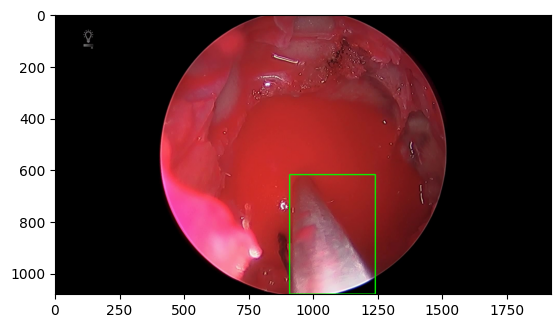


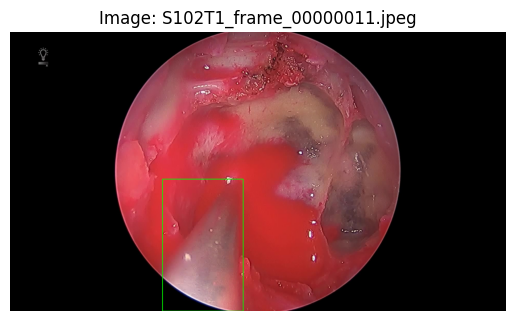

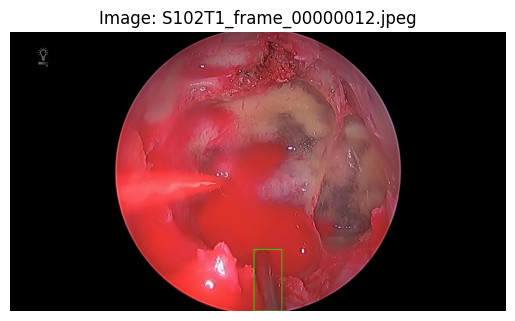

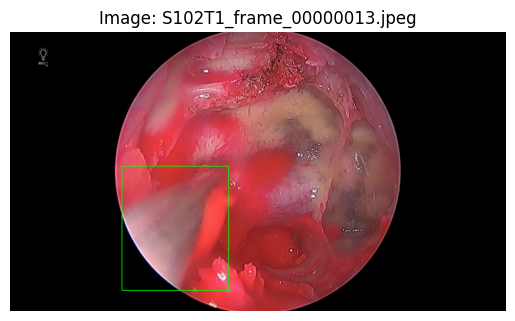

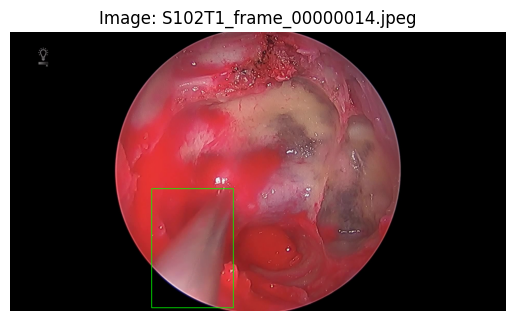

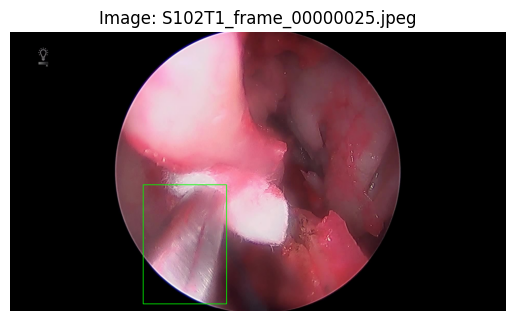

In [55]:
import cv2
import matplotlib.pyplot as plt


def show_image_with_labels(image_file, label_file):
    # Load image
    img_path = os.path.join(images_path, image_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape
    # Load labels
    with open(os.path.join(labels_path, label_file), 'r') as f:
        for line in f.readlines():
              cls, x, y, bw, bh = map(float, line.strip().split())
              #print(line.strip().split())
              # Convert normalized coordinates to pixel values
              x1 = int((x - bw / 2) * w)
              y1 = int((y - bh / 2) * h)
              x2 = int((x + bw / 2) * w)
              y2 = int((y + bh / 2) * h)
              cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    plt.imshow(img)
    plt.title(f"Image: {image_file}")
    plt.axis('off')
    plt.show()

# Example usage:
images_to_display= 5
for ind in range(min(images_to_display,len(valid_image_files))):
  show_image_with_labels(valid_image_files[ind], valid_label_files[ind])

## II. Embeddings with VideoMAE-2

Download the small demo dataset of surgical videos we have prepared. This dataset has 4 videos from 2 procedure types: Pituitary Tumor Surgery and Cholecystectomy.

The Cholecystectomy videos come from the cholec80 dataset is an endoscopic video dataset containing 80 videos of cholecystectomy surgeries performed by 13 surgeons. The videos are captured at 25 fps and downsampled to 1 fps for processing. The whole dataset is labeled with the phase and tool presence annotations. The phases have been defined by a senior surgeon in Strasbourg hospital, France. Since the tools are sometimes hardly visible in the images and thus difficult to be recognized visually, a tool is defined as present in an image if at least half of the tool tip is visible.



From google drive, either copy the dataset surgical_videos_demo to your drive or find the path to the shared folder. The link to the folder is: https://drive.google.com/drive/folders/1wm5JtGBNETbFx5PHexLIEq85O6YVkIIQ?usp=sharing


[link text](https://)#### 1. Check that you have 4 videos in the dataset, explore the structure of the dataset

In [56]:
import cv2
import os

def is_videos_valid(base_path):
  valid_video_files =[]
  video_files = sorted([f for f in os.listdir(base_path) if f.endswith(('.mp4'))])
  for video_file in video_files:
    file_path_whole=os.path.join(base_path,video_file)
    cap = cv2.VideoCapture(file_path_whole)
    if not cap.isOpened():
        print("Error: Cannot open video")
    else:
      valid_video_files.append(file_path_whole)
      fps = cap.get(cv2.CAP_PROP_FPS)
      frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
      width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
      height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
      duration = frame_count / fps if fps else 0
      print("---details of "+video_file+"-------")

      print(f"FPS: {fps}")
      print(f"Total frames: {frame_count}")
      print(f"Resolution: {width}x{height}")
      print(f"Duration: {duration:.2f} seconds")
      print("-------")

  return valid_video_files


In [57]:
# explore dataset
base_path = r'/content/drive/My Drive/SDSC/Surgical_videos/surgical_videos_demo'
base_path_cholecystectomy = os.path.join(base_path, 'Cholecystectomy')
base_path_pts = os.path.join(base_path, 'pituitary_tumor_surgery')
print("cholecystectomy files ")
valid_cholecystectomy_files = is_videos_valid(base_path_cholecystectomy)
print("pituitary tumor surgery files ")
valid_pts_files = is_videos_valid(base_path_pts)
total_file_length = len(valid_cholecystectomy_files)+len(valid_pts_files)
print("___________OBSERVATION________________________")
print(str(total_file_length) +"videos in the dataset")
print("____________________________________________")


cholecystectomy files 
---details of video01.mp4-------
FPS: 25.0
Total frames: 43326
Resolution: 854x480
Duration: 1733.04 seconds
-------
---details of video02.mp4-------
FPS: 24.926459052400375
Total frames: 25421
Resolution: 854x480
Duration: 1019.84 seconds
-------
pituitary tumor surgery files 
---details of video-0.mp4-------
FPS: 30.0
Total frames: 11023
Resolution: 854x480
Duration: 367.43 seconds
-------
---details of video-1.mp4-------
FPS: 30.0
Total frames: 6274
Resolution: 854x480
Duration: 209.13 seconds
-------
___________OBSERVATION________________________
4videos in the dataset
____________________________________________


#### 2. Display some random frames from the videos

In [58]:
import random
def display_random_frames(video_files,num_samples = None,list_indices =None):
  for video_file in video_files:
    print("video file:",video_file)
    cap = cv2.VideoCapture(os.path.join(base_path,video_file))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if num_samples is None and list_indices is not None:
      if list_indices is None:
        random_frame_indices = range(min(10,total_frames))
      else:
        random_frame_indices =list_indices
    else:
      random_frame_indices = sorted(random.sample(range(total_frames), num_samples))
    print("Random frames to sample:", random_frame_indices)
    frames_shown = 0
    for idx in random_frame_indices:
      print(idx)

      cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
      ret, frame = cap.read()
      if not ret:
          continue
      frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

      plt.figure(figsize=(5, 5))
      plt.imshow(frame_rgb)
      plt.title(f"Frame #{idx}")
      plt.axis('off')
      plt.show()

      frames_shown += 1

    cap.release()




display_random_frames for cholecystectomy
video file: /content/drive/My Drive/SDSC/Surgical_videos/surgical_videos_demo/Cholecystectomy/video01.mp4
Random frames to sample: [2936, 26411]
2936


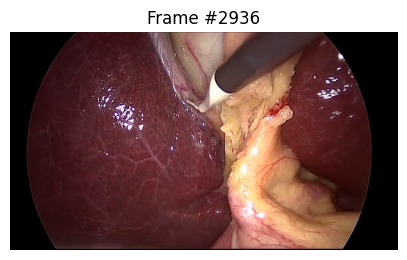

26411


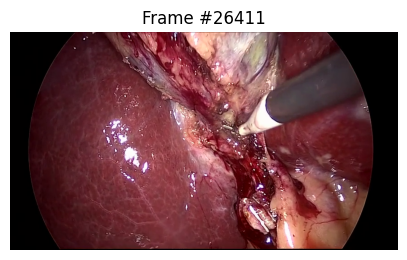

video file: /content/drive/My Drive/SDSC/Surgical_videos/surgical_videos_demo/Cholecystectomy/video02.mp4
Random frames to sample: [8134, 23326]
8134


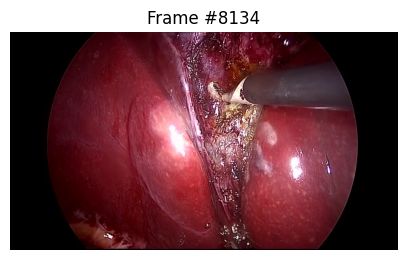

23326


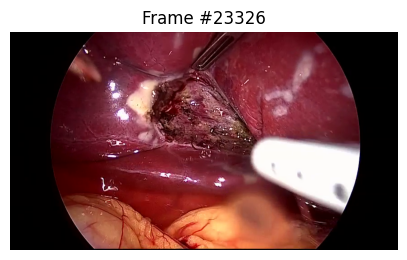

display_random_frames for pts


In [59]:
print("display_random_frames for cholecystectomy")
display_random_frames(valid_cholecystectomy_files,2)
print("display_random_frames for pts")
#display_random_frames(valid_pts_files,2)


#### 3. Display the VideoMAE-2 embeddings
Use the model VideoMAE-2 from huggingface: https://huggingface.co/docs/transformers/model_doc/videomae to visualize the embeddings graph of the videos from the surgical videos dataset. See the Examples section in the huggingface page to find useful functions.

Some help: You need to sample 16 frames as mentioned in the videomae paper: "Our backbone is 16-frame vanilla ViT-B".

You can have a sample rate: sample frames every x frames.

In [60]:
!pip install transformers && pip install av accelerate decord einops

In [61]:
# imports you might need for that section
import numpy as np
from numpy.linalg import norm
import torch
import av
from transformers import AutoImageProcessor, VideoMAEModel
import torchvision.transforms as transforms
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

In [62]:
#2. Load the VideoMAE Model + Image Processor
from transformers import AutoImageProcessor, VideoMAEModel
device = "cuda" if torch.cuda.is_available() else "cpu"
image_processor = AutoImageProcessor.from_pretrained("MCG-NJU/videomae-base")
model_videomae_base = VideoMAEModel.from_pretrained("MCG-NJU/videomae-base", output_hidden_states=True)
model_videomae_base.eval()

VideoMAEModel(
  (embeddings): VideoMAEEmbeddings(
    (patch_embeddings): VideoMAEPatchEmbeddings(
      (projection): Conv3d(3, 768, kernel_size=(2, 16, 16), stride=(2, 16, 16))
    )
  )
  (encoder): VideoMAEEncoder(
    (layer): ModuleList(
      (0-11): 12 x VideoMAELayer(
        (attention): VideoMAEAttention(
          (attention): VideoMAESelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=False)
            (key): Linear(in_features=768, out_features=768, bias=False)
            (value): Linear(in_features=768, out_features=768, bias=False)
          )
          (output): VideoMAESelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): VideoMAEIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): VideoMAEOutput

**Use** the model_videomae_base to generate the embeddings of the videos from the dataset and then visualize them in a graph.

Expected output would look like this:
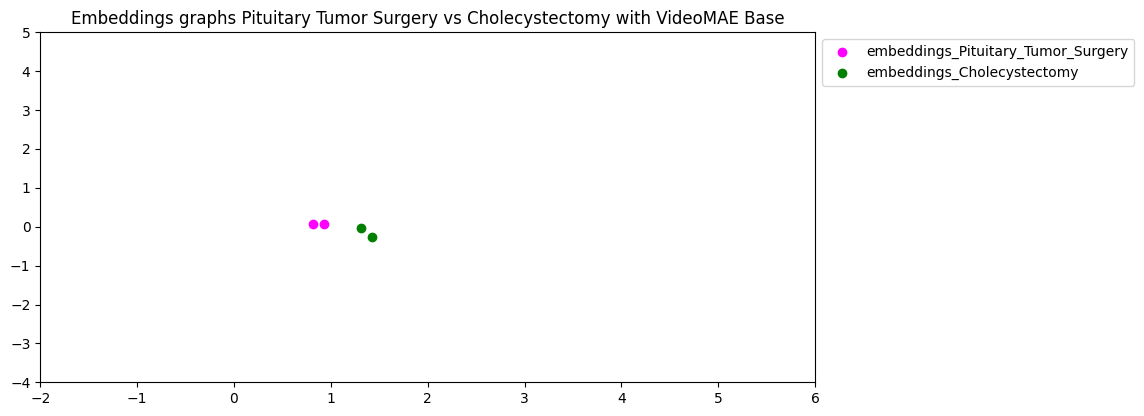

In [63]:
# Function to sample and process frames
from decord import VideoReader, cpu

def load_video(path, num_frames=16):
    vr = VideoReader(path, ctx=cpu(0))
    total = len(vr)
    final_valid_index = int(total -0.01*total)# as 1 cholstoctemy file hasd not surgery fram in last frames
    indices = np.linspace(0, final_valid_index, num_frames, dtype=int)
    video = vr.get_batch(indices).asnumpy()  # (T, H, W, C)
    return video,indices



/content/drive/My Drive/SDSC/Surgical_videos/surgical_videos_demo/Cholecystectomy/video01.mp4
[0, 2859, 5718, 8578, 11437, 14297, 17156, 20016, 22875, 25735, 28594, 31454, 34313, 37173, 40032, 42892]
video file: /content/drive/My Drive/SDSC/Surgical_videos/surgical_videos_demo/Cholecystectomy/video01.mp4
Random frames to sample: [0, 2859, 5718, 8578, 11437, 14297, 17156, 20016, 22875, 25735, 28594, 31454, 34313, 37173, 40032, 42892]
0


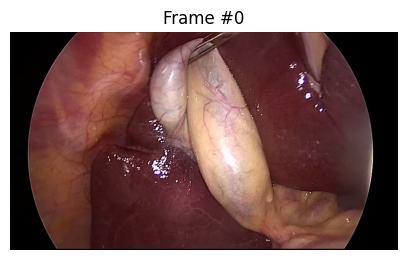

2859


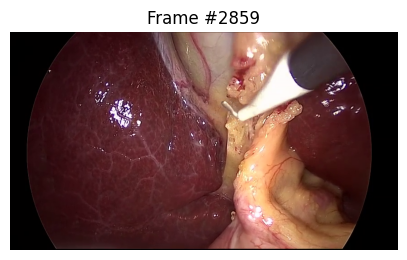

5718


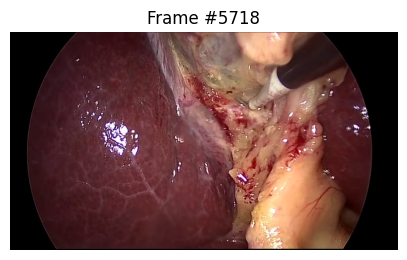

8578


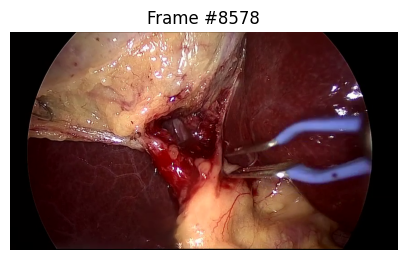

11437


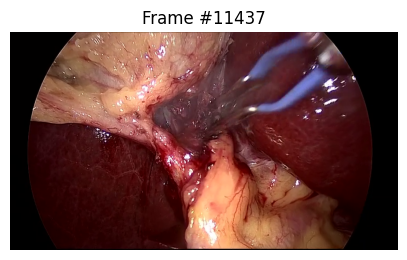

14297


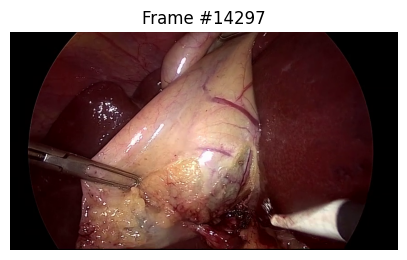

17156


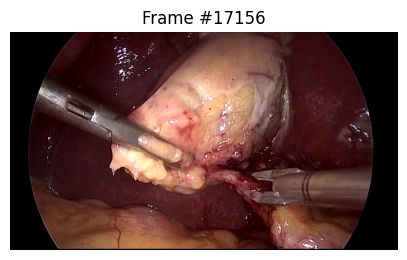

20016


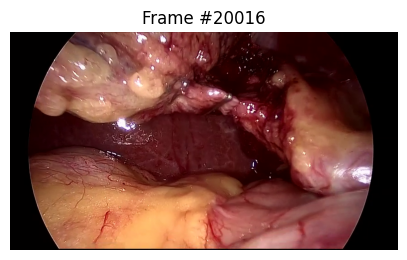

22875


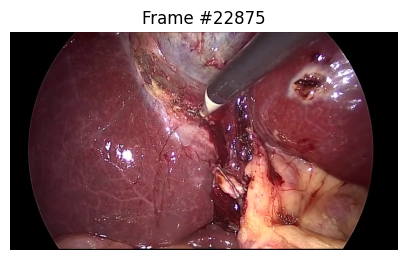

25735


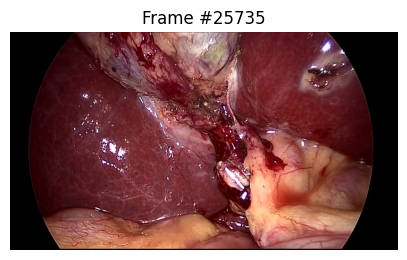

28594


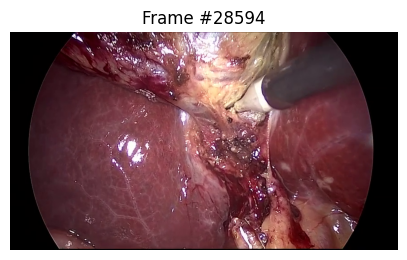

31454


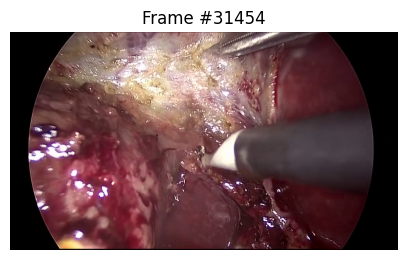

34313


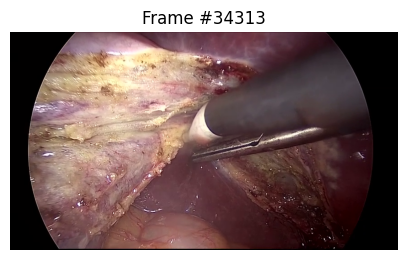

37173


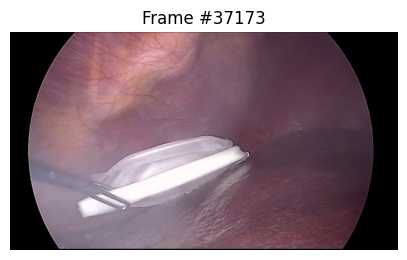

40032


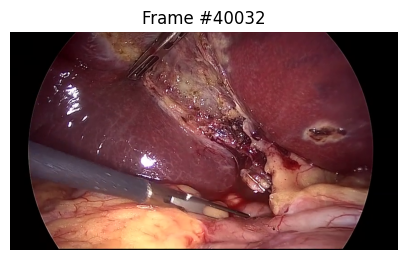

42892


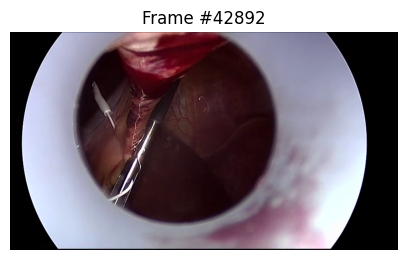

Processed /content/drive/My Drive/SDSC/Surgical_videos/surgical_videos_demo/Cholecystectomy/video01.mp4


In [64]:
#images that go into transformer
video_files1 = valid_cholecystectomy_files#+valid_pts_files
for file in [video_files1[0]]:
    try:
        print(file)
        video,indices = load_video(file)
        print(indices.tolist())
        py_list = [int(x) for x in indices]

        display_random_frames([file],None,py_list)
        print(f"Processed {file}")
    except Exception as e:
        print(f"Failed {file}: {e}")

In [65]:
#Extract embeddings from a videomae
def get_videomae_embedding(video_array):
    # video_array: (T, H, W, C)
    inputs = image_processor(list(video_array), return_tensors="pt")
    pixel_values = inputs["pixel_values"].to(device)  # (1, 3, T, H, W)

    with torch.no_grad():
        outputs = model_videomae_base(pixel_values)
        embedding = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()  # shape: (768,)
    return embedding

In [66]:
def plot_embeddings(reduced, labels,label_legend, reduction_alg = None):
  data_to_plot = reduced.shape[0]
  plt.figure(figsize=(10, 6))
  for ind in range(data_to_plot):
    if labels[ind] == 0:
      plt.scatter(reduced[ind, 0], reduced[ind, 1], c='green',label=label_legend[0] ,alpha=0.7)
    else:
      plt.scatter(reduced[ind, 0], reduced[ind, 1], c='magenta',label=label_legend[1] ,alpha=0.7)
  if reduction_alg is None:
    plt.title("Video Embeddings by VideoMAE")
  else:
    plt.title(f"Video Embeddings by VideoMAE with {reduction_alg}")
  handles, labels = plt.gca().get_legend_handles_labels()
  unique = dict(zip(labels, handles))  # keeps the *last* occurrence of each label
  plt.legend(unique.values(), unique.keys(),framealpha=0)
  plt.xlabel("Dim 1")
  plt.ylabel("Dim 2")
  plt.grid(True)
  plt.show()

In [67]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
video_files_final = valid_cholecystectomy_files+valid_pts_files
print(video_files_final)
labels = [0] * len(valid_cholecystectomy_files) + [1] * len(valid_pts_files)
label_legend = {0:'embeddings_cholecystectomy', 1:'embeddings_Pituitary_tumor_surgery'}

embeddings_all = []
video_names = []
failed_to_load  = 0
for file in video_files_final:
    try:
        video,_ = load_video(file)
        emb = get_videomae_embedding(video)
        embeddings_all.append(emb)
        video_names.append(file)
        print(f"Processed {file}")
    except Exception as e:
        failed_to_load+=1
        print(f"Failed {file}: {e}")
if failed_to_load >0:
  print("___OBSERVATION_____")
  print("Cannot load " + str(failed_to_load) + " videos")
  print("________")


['/content/drive/My Drive/SDSC/Surgical_videos/surgical_videos_demo/Cholecystectomy/video01.mp4', '/content/drive/My Drive/SDSC/Surgical_videos/surgical_videos_demo/Cholecystectomy/video02.mp4', '/content/drive/My Drive/SDSC/Surgical_videos/surgical_videos_demo/pituitary_tumor_surgery/video-0.mp4', '/content/drive/My Drive/SDSC/Surgical_videos/surgical_videos_demo/pituitary_tumor_surgery/video-1.mp4']
Processed /content/drive/My Drive/SDSC/Surgical_videos/surgical_videos_demo/Cholecystectomy/video01.mp4
Processed /content/drive/My Drive/SDSC/Surgical_videos/surgical_videos_demo/Cholecystectomy/video02.mp4
Processed /content/drive/My Drive/SDSC/Surgical_videos/surgical_videos_demo/pituitary_tumor_surgery/video-0.mp4
Processed /content/drive/My Drive/SDSC/Surgical_videos/surgical_videos_demo/pituitary_tumor_surgery/video-1.mp4


[[ 2.136771   -1.1361035 ]
 [ 2.4707074   1.0528299 ]
 [-2.244621    0.19557181]
 [-2.3628576  -0.11229806]]


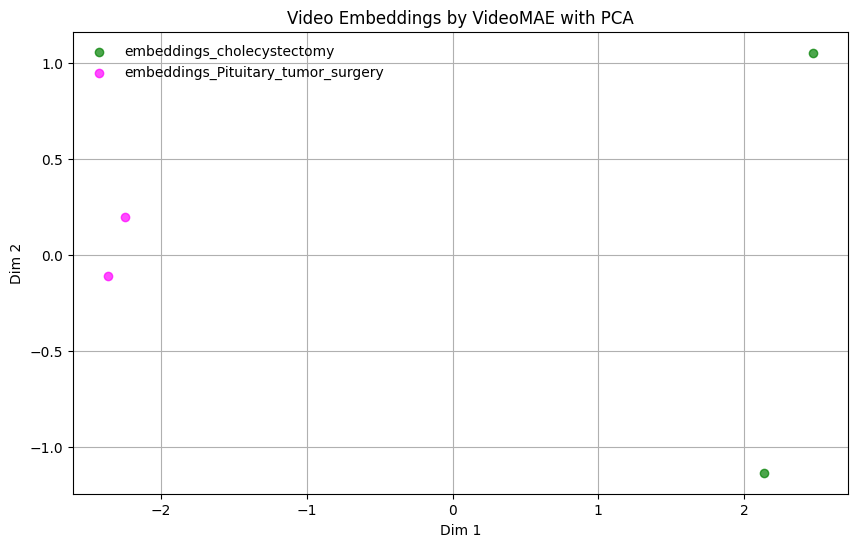

[[ 2.1367733  -1.1361032 ]
 [ 2.4707065   1.0528296 ]
 [-2.2446208   0.19557165]
 [-2.3628573  -0.11229837]]


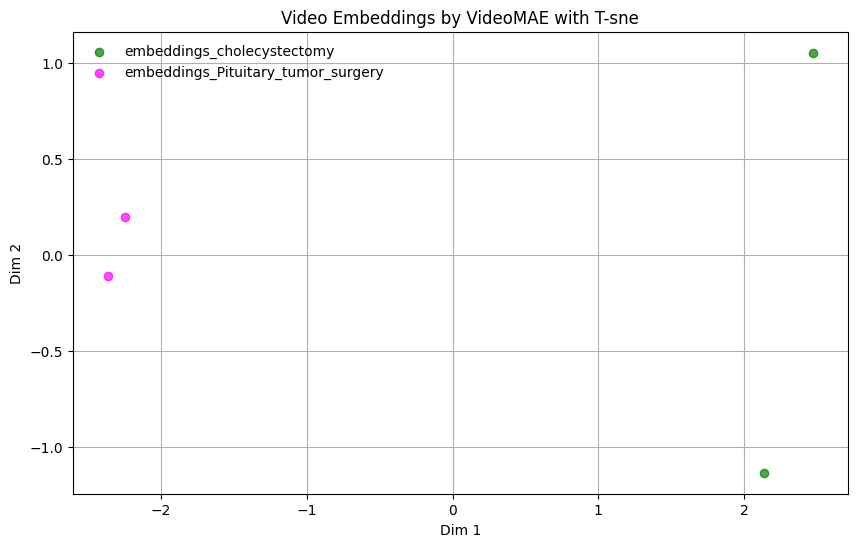

In [68]:


# reduce dimension
# PCA (faster) or TSNE (more expressive)
pca = PCA(n_components=2)
reduced = pca.fit_transform(np.array(embeddings_all))
print(reduced)
plot_embeddings(reduced,labels,label_legend, "PCA")

tsne = TSNE(n_components=2)  # Optional
reduced = pca.fit_transform(np.array(embeddings_all))
print(reduced)
plot_embeddings(reduced,labels,label_legend, "T-sne")


TODO: Comment what you can observe here.

OBSERVATION I can see that putuitary tumor surgery are close that means that the procedures are similar  it can imply maybe it was done by the samme surgeon  compared to the cholescyctomy . Both sets are disrtibuted wide apart that means it was operted on differnt organs and procedure is diffrent  

## III. BONUS: Use the VideoMAE model to predict the outcome of the procedure from the SOCAL dataset


You can find the column "success" in the file socal_trial_outcomes.csv. Create an ML dataset ready for training the videomae model and run the training + Evaluation.

You can find the full SOCAL dataset here: https://drive.google.com/drive/folders/1xGcGkbj34wgETuzSafa5hZw5WAdRdtG4?usp=sharing

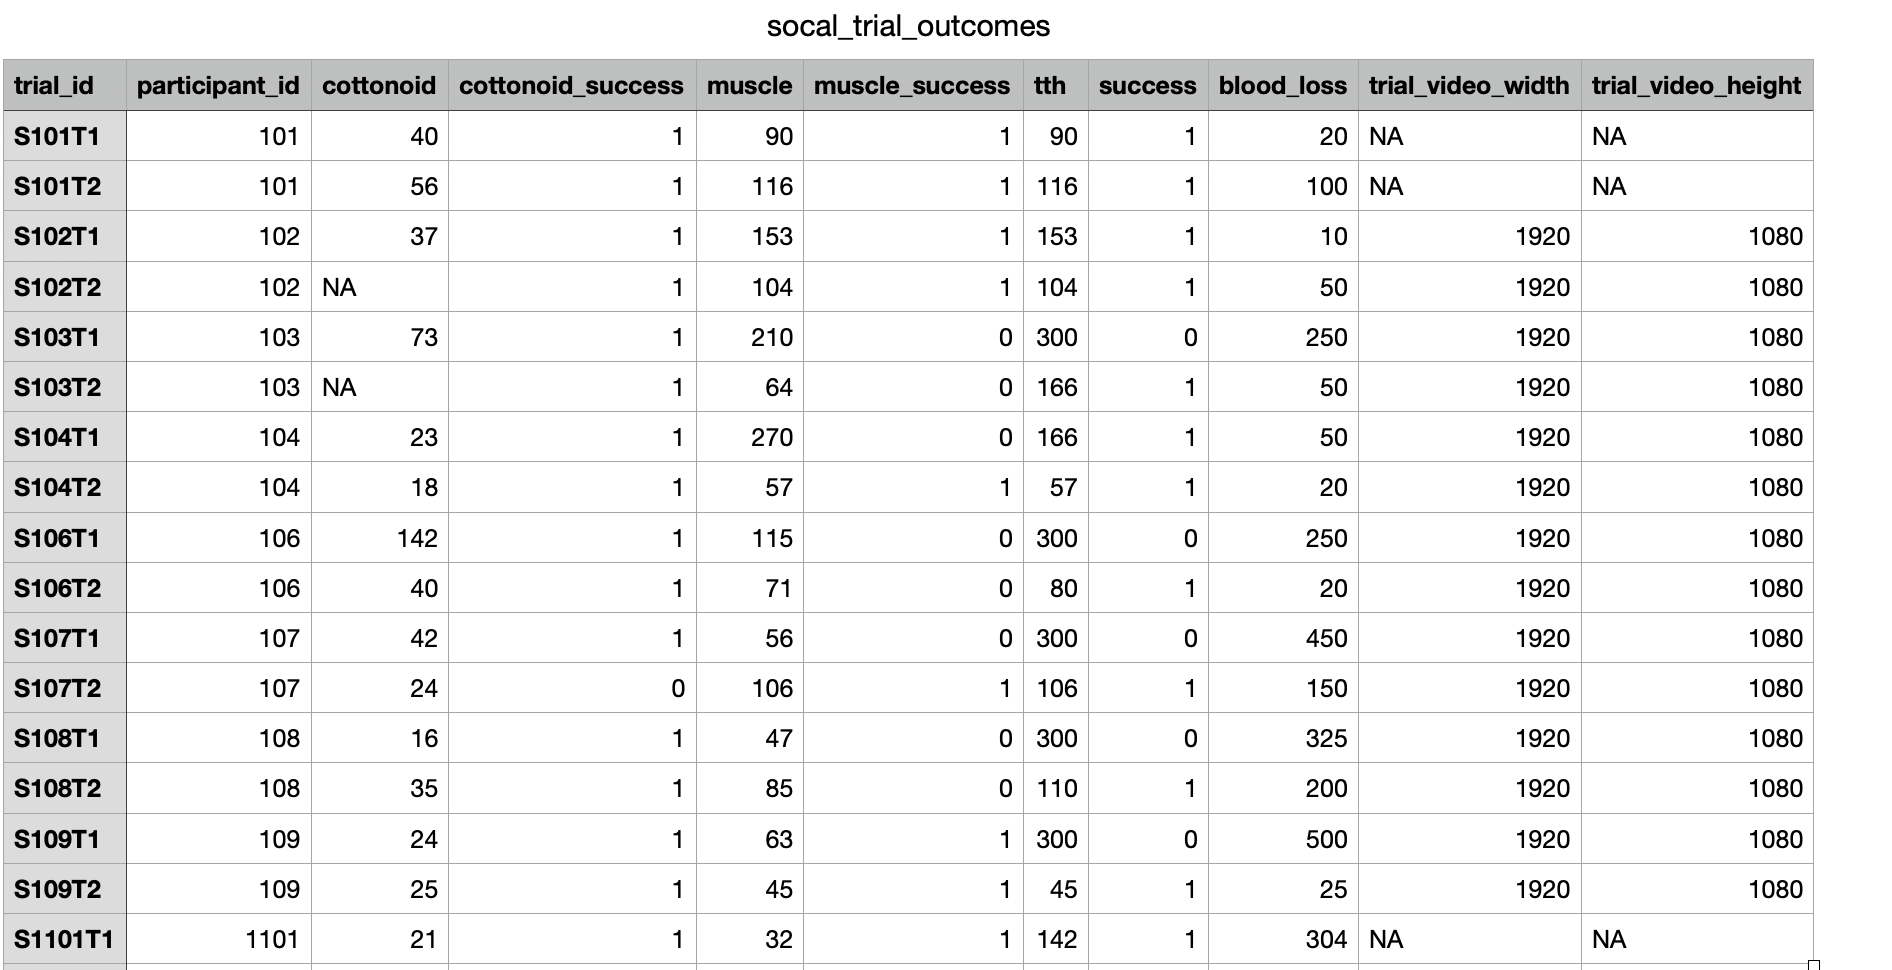

Some code to help get started with the training can be found on huggingface page: https://huggingface.co/docs/transformers/v4.34.1/en/model_doc/videomae#transformers.VideoMAEForVideoClassification

This notebook is also useful: https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/video_classification.ipynb

In [81]:
# read the csv
import pandas as pd
import os
base_path = r'/content/drive/My Drive/SDSC/TrainSOCAL/SOCAL'



In [82]:
import os
from collections import defaultdict
images_path = os.path.join(base_path, 'JPEGImages')

def split_filenames_to_dict(folder_path):
    """
    Extracts unique_id and frame_name from filenames and groups them in a dictionary.
    Assumes filenames are like: uniqueid_framename.ext (e.g., procedure01_frame0001.jpg)
    """
    grouped = defaultdict(list)
    image_files = sorted([f for f in os.listdir(images_path) if f.endswith(('.jpeg'))])

    for filename in image_files:

        base = os.path.splitext(filename)[0]  # remove extension
        parts = base.split('_', 1)  # split at first underscore only

        if len(parts) == 2:
            unique_id, frame_name = parts
            grouped[unique_id].append(filename)
        else:
            print(f"Skipping unexpected filename format: {filename}")

    return dict(grouped)
procedure_dict =split_filenames_to_dict(images_path)
print("number of unique procedure is in the folder " +str(len(procedure_dict.keys())))

number of unique procedure is in the folder 158


In [83]:
# get labels of the unique ids
labels_df = pd.read_csv(os.path.join(base_path,'socal_trial_outcomes.csv'))
# Only keep rows where the ID exists in your frame dict
valid_ids = set(procedure_dict.keys())
filtered_df = labels_df[labels_df['trial_id'].isin(valid_ids)]
print(len(filtered_df))
# Optional: only keep rows where success == 1
label = filtered_df['success']
label_dict = dict(zip(filtered_df['trial_id'], filtered_df['success']))
print(" unique procedure that has label " +str(len(label)))
print("Missing  labels "+str((len(procedure_dict.keys())) -len(label)))

combined_dict = {}
missing_label_dict = {}
for uid, frames in procedure_dict.items():
    label = label_dict.get(uid)  # will be None if missing
    if label is not None:
        combined_dict[uid] = {
            'frames': frames,
            'label': label
        }
    else:
        print(f"Warning: No label found for {uid}")
        missing_label_dict[uid] = frames

# Optionally remove all procedures with missing labels from the original frame_dict
for uid in missing_label_dict:
    procedure_dict.pop(uid)

print(procedure_dict)

132
 unique procedure that has label 132
Missing  labels 26
{'S102T1': ['S102T1_frame_00000002.jpeg', 'S102T1_frame_00000003.jpeg', 'S102T1_frame_00000004.jpeg', 'S102T1_frame_00000005.jpeg', 'S102T1_frame_00000007.jpeg', 'S102T1_frame_00000008.jpeg', 'S102T1_frame_00000009.jpeg', 'S102T1_frame_00000011.jpeg', 'S102T1_frame_00000012.jpeg', 'S102T1_frame_00000013.jpeg', 'S102T1_frame_00000014.jpeg', 'S102T1_frame_00000015.jpeg', 'S102T1_frame_00000018.jpeg', 'S102T1_frame_00000019.jpeg', 'S102T1_frame_00000022.jpeg', 'S102T1_frame_00000023.jpeg', 'S102T1_frame_00000024.jpeg', 'S102T1_frame_00000025.jpeg', 'S102T1_frame_00000027.jpeg', 'S102T1_frame_00000028.jpeg', 'S102T1_frame_00000029.jpeg', 'S102T1_frame_00000031.jpeg', 'S102T1_frame_00000032.jpeg', 'S102T1_frame_00000033.jpeg', 'S102T1_frame_00000034.jpeg', 'S102T1_frame_00000035.jpeg', 'S102T1_frame_00000038.jpeg', 'S102T1_frame_00000039.jpeg', 'S102T1_frame_00000042.jpeg', 'S102T1_frame_00000043.jpeg', 'S102T1_frame_00000044.jpeg'

In [84]:
# pip install transformers decord einops torch torchvision # as is already done in previos methos hence  commenting

In [85]:
# START training

In [86]:
# 1.Load the VideoMAE and Processor
from transformers import AutoImageProcessor, VideoMAEForVideoClassification
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoImageProcessor.from_pretrained("MCG-NJU/videomae-base")
model = VideoMAEForVideoClassification.from_pretrained(
    "MCG-NJU/videomae-base",
    num_labels=2,  # binary classification: success/failure
    ignore_mismatched_sizes=True
).to(device)

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [87]:
# 2.defining the custom dataset
import os
from PIL import Image
import torch
from torch.utils.data import Dataset

class SocalFrameDataset(Dataset):
    def __init__(self, data_dict, root_folder, processor, num_frames=16):
        """
        data_dict: {
            'procedure01': {
                'frames': [...],
                'label': 1
            },
            ...
        }
        """
        self.entries = list(data_dict.items())
        self.root_folder = root_folder
        self.processor = processor
        self.num_frames = num_frames

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        unique_id, data = self.entries[idx]
        frame_list = sorted(data["frames"])
        label = data["label"]

        total = len(frame_list)
        if total < self.num_frames:
            raise ValueError(f"Not enough frames in {unique_id} (only {total})")

        # Sample 16 evenly spaced frames
        indices = [round(i * (total - 1) / (self.num_frames - 1)) for i in range(self.num_frames)]
        selected_frames = [frame_list[i] for i in indices]

        # Load and process frames
        images = [Image.open(os.path.join(self.root_folder, fname)).convert("RGB") for fname in selected_frames]
        processed = self.processor(images, return_tensors="pt")

        pixel_values = processed["pixel_values"].squeeze(0)  # (3, T, H, W)
        return {
            "pixel_values": pixel_values,
            "labels": torch.tensor(label, dtype=torch.long)
        }


In [88]:
# 4.Get train and validation dict
from sklearn.model_selection import train_test_split

# Step 1: Extract keys and labels
keys = list(combined_dict.keys())
labels = [combined_dict[k]['label'] for k in keys]

# Step 2: Stratified split
train_keys, val_keys = train_test_split(
    keys,
    test_size=0.2,
    stratify=labels,
    random_state=21
)

# Step 3: Reconstruct train and val dicts
train_dict = {k: combined_dict[k] for k in train_keys}
val_dict = {k: combined_dict[k] for k in val_keys}

In [89]:
# 5. define dataloader
from torch.utils.data import DataLoader

train_dataset = SocalFrameDataset(train_dict, root_folder=images_path, processor=processor)
val_dataset = SocalFrameDataset(val_dict, root_folder=images_path, processor=processor)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2)

In [78]:
# 6. training loop
from torch.optim import AdamW
from tqdm import tqdm

import torch.nn as nn

loss_fn = nn.CrossEntropyLoss()

checkpoint_dir = "content/drive/My Drive/SDSC/TrainSOCAL/model_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

best_val_loss = float('inf')

optimizer = AdamW(model.parameters(), lr=1e-5)
train_steps = 3
for epoch in range(train_steps):
    model.train()
    for batch in tqdm(train_loader):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f"Epoch {epoch+1} train loss: {loss.item():.4f}")
    # === Validation === to save the checkcpoint
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(val_loader):
          outputs = model(pixel_values=batch['pixel_values'].to(device))
          loss = loss_fn(outputs.logits, batch['labels'].to(device))
          val_loss += loss.item()

    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}")

    # Save checkpoint if this is the best so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_path = os.path.join(checkpoint_dir, "best_model.pt")
        torch.save(model.state_dict(), save_path)
        print(" Saved new best model")


100%|██████████| 53/53 [39:37<00:00, 44.86s/it]


Epoch 1 train loss: 1.4809


100%|██████████| 14/14 [04:59<00:00, 21.36s/it]


Epoch 1, Validation Loss: 0.6324
 Saved new best model


100%|██████████| 53/53 [27:52<00:00, 31.56s/it]


Epoch 2 train loss: 0.7779


100%|██████████| 14/14 [02:28<00:00, 10.58s/it]


Epoch 2, Validation Loss: 0.5511
 Saved new best model


100%|██████████| 53/53 [27:49<00:00, 31.50s/it]


Epoch 3 train loss: 0.2897


100%|██████████| 14/14 [02:21<00:00, 10.10s/it]


Epoch 3, Validation Loss: 0.5395
 Saved new best model


In [79]:
checkpoint_path = os.path.join(checkpoint_dir, "best_model.pt")
print(os.path.exists(checkpoint_path))

True


In [80]:
# 7.Evaluation
from sklearn.metrics import classification_report

# Load model
checkpoint_path = os.path.join(checkpoint_dir, "best_model.pt")
model.load_state_dict(torch.load(checkpoint_path))
model.eval()

all_preds = []
all_labels = []
count=0
with torch.no_grad():
    for batch in tqdm(val_loader):
      pixel_values = batch["pixel_values"].to(device)
      labels = batch["labels"].to(device)

      outputs = model(pixel_values=pixel_values)
      preds = outputs.logits.argmax(dim=-1)

      all_preds.extend(preds.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds))


100%|██████████| 14/14 [02:18<00:00,  9.91s/it]

              precision    recall  f1-score   support

           0       0.57      0.89      0.70         9
           1       0.92      0.67      0.77        18

    accuracy                           0.74        27
   macro avg       0.75      0.78      0.73        27
weighted avg       0.81      0.74      0.75        27

